In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import csv, ast, psycopg2
import os
import sqlite3
import gzip
import seaborn as sns
import matplotlib.pyplot as plt
import json 
from chart_studio.plotly import iplot
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
import statistics


from sqlite3 import Error
from collections import Counter

def create_connection(db_file, delete_db=False):
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn


def create_table(conn, create_table_sql):
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def execute_sql(query_sql):

    c = conn.cursor()
    c.execute(query_sql)
    conn.commit()
    rows = pd.DataFrame(c.fetchall())
    return rows


In [2]:
df = pd.read_csv('survey_results_public.csv')
df.head()

/home/mavericku/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning:

Columns (8,12,13,14,15,16,50,51,52,53,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128) have mixed types. Specify dtype option on import or set low_memory=False.



,Respondent,Hobby,OpenSource,Country,Student,Employment,FormalEducation,UndergradMajor,CompanySize,DevType,...,Exercise,Gender,SexualOrientation,EducationParents,RaceEthnicity,Age,Dependents,MilitaryUS,SurveyTooLong,SurveyEasy
0,1,Yes,No,Kenya,No,Employed part-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Mathematics or statistics,20 to 99 employees,Full-stack developer,...,3 - 4 times per week,Male,Straight or heterosexual,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Black or of African descent,25 - 34 years old,Yes,NaN,The survey was an appropriate length,Very easy
1,3,Yes,Yes,United Kingdom,No,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","A natural science (ex. biology, chemistry, phy...","10,000 or more employees",Database administrator;DevOps specialist;Full-...,...,Daily or almost every day,Male,Straight or heterosexual,"Bachelor’s degree (BA, BS, B.Eng., etc.)",White or of European descent,35 - 44 years old,Yes,NaN,The survey was an appropriate length,Somewhat easy
2,4,Yes,Yes,United States,No,Employed full-time,Associate degree,"Computer science, computer engineering, or sof...",20 to 99 employees,Engineering manager;Full-stack developer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,No,No,United States,No,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",100 to 499 employees,Full-stack developer,...,I don't typically exercise,Male,Straight or heterosexual,Some college/university study without earning ...,White or of European descent,35 - 44 years old,No,No,The survey was an appropriate length,Somewhat easy
4,7,Yes,No,South Africa,"Yes, part-time",Employed full-time,Some college/university study without earning ...,"Computer science, computer engineering, or sof...","10,000 or more employees",Data or business analyst;Desktop or enterprise...,...,3 - 4 times per week,Male,Straight or heterosexual,Some college/university study without earning ...,White or of European descent,18 - 24 years old,Yes,NaN,The survey was an appropriate length,Somewhat easy


## AUTOMATE TABLE CREATION

We first input the files in to the Database

In [3]:
## Determining data type
def determine_data_type_of_list(values):  
    if type(values) == list:
        do_float = 0
        do_string = 0
        do_int = 0
        for x in values: 
            #print(x)
            try: 
                test_x_float = float(x) 
                try:
                    test_x_int = int(x) 
                except:
                    test_x_int = float(x)
                    do_float += 1 
                if int(test_x_float) == test_x_int:  
                    do_int +=1
                else:
                    do_float +=1 
            except:              
                do_string +=1
                 
        if do_string >0: 
            return str
        elif do_float > 0 : 
            return float
        else : 
            return int 
    else:
        return determine_data_type(values)

In [4]:
all_columns = [] 
main_table = "stack_overflow_survey"

In [5]:
statement = 'create table if not exists ' + main_table  + ' (' 
for column in df.columns.values:
    all_columns.append(column)
    column_data_type = determine_data_type_of_list(df[column].tolist())
#     print(column_data_type)
    if column_data_type == str: 
        statement = (statement + '\n{} text,').format(column.lower() )
    elif column == "Respondent":
        
        statement = (statement + '\n{} int not null primary key,').format(column.lower() )
    else:
        statement = (statement + '\n' + '{} {}' + ',').format(column.lower(), "int") 
statement = statement[:-1] + ');' 

In [6]:
#CREATE TABLES
create_table_sql = statement
sql_table_name = "Stack_Over_Flow_Survey.db"
conn = create_connection(sql_table_name) 
create_table(conn , create_table_sql)

In [8]:
insert_sql = """INSERT INTO stack_overflow_survey (respondent, hobby, opensource, country, student, employment, formaleducation, undergradmajor, companysize, devtype, yearscoding, yearscodingprof, jobsatisfaction, careersatisfaction, hopefiveyears, jobsearchstatus, lastnewjob, assessjob1, assessjob2, assessjob3, assessjob4, assessjob5, assessjob6, assessjob7, assessjob8, assessjob9, assessjob10, assessbenefits1, assessbenefits2, assessbenefits3, assessbenefits4, assessbenefits5, assessbenefits6, assessbenefits7, assessbenefits8, assessbenefits9, assessbenefits10, assessbenefits11, jobcontactpriorities1, jobcontactpriorities2, jobcontactpriorities3, jobcontactpriorities4, jobcontactpriorities5, jobemailpriorities1, jobemailpriorities2, jobemailpriorities3, jobemailpriorities4, jobemailpriorities5, jobemailpriorities6, jobemailpriorities7, updatecv, currency, salary, salarytype, convertedsalary, currencysymbol, communicationtools, timefullyproductive, educationtypes, selftaughttypes, timeafterbootcamp, hackathonreasons, agreedisagree1, agreedisagree2, agreedisagree3, languageworkedwith, languagedesirenextyear, databaseworkedwith, databasedesirenextyear, platformworkedwith, platformdesirenextyear, frameworkworkedwith, frameworkdesirenextyear, ide, operatingsystem, numbermonitors, methodology, versioncontrol, checkincode, adblocker, adblockerdisable, adblockerreasons, adsagreedisagree1, adsagreedisagree2, adsagreedisagree3, adsactions, adspriorities1, adspriorities2, adspriorities3, adspriorities4, adspriorities5, adspriorities6, adspriorities7, aidangerous, aiinteresting, airesponsible, aifuture, ethicschoice, ethicsreport, ethicsresponsible, ethicalimplications, stackoverflowrecommend, stackoverflowvisit, stackoverflowhasaccount, stackoverflowparticipate, stackoverflowjobs, stackoverflowdevstory, stackoverflowjobsrecommend, stackoverflowconsidermember, hypotheticaltools1, hypotheticaltools2, hypotheticaltools3, hypotheticaltools4, hypotheticaltools5, waketime, hourscomputer, hoursoutside, skipmeals, ergonomicdevices, exercise, gender, sexualorientation, educationparents, raceethnicity, age, dependents, militaryus, surveytoolong, surveyeasy) 
VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
"""
# insert_
# # print(statement)
# print(len(all_columns))

# for i in range(0 , 129):
#     print("?, ", end = "")

In [9]:
# print(insert_sql)

In [10]:
# INSERT FUNCTION
def insert_rows_to_db(conn, data_tuple): 
    try:
        c = conn.cursor()
        c.executemany(insert_sql, data_tuple)
        conn.commit()
    except Error as e:  
        print(e)

In [11]:
# EXTRACT DATA
index_print_times = 0
test_times = 30
all_respondet_answer_tuple = []
for index, value in  df.iterrows(): 
    respondent_answer_tuple = [] 
    for columns in all_columns: 
        respondent_answer_tuple.append(value[columns])
        index_print_times += 1  
#     insert_rows_to_db(conn, tuple(respondent_answer_tuple))
    all_respondet_answer_tuple.append(tuple(respondent_answer_tuple)) 
    
############### IF ERROR, DELETE .DB FILE THEN RERUN #########################

In [12]:
# INSERT TO DB
insert_rows_to_db(conn, all_respondet_answer_tuple)

UNIQUE constraint failed: stack_overflow_survey.respondent


# First, we analyze our users

We first take a look at the respondents that have taken the survey
We wish to know
1. The amount of respondents from each of the countries
2. The male/female ratio
3. The age group of respondents
4. How many code as a hobby
5. The typical degree type and major
6. Type of developer

In [13]:
select_sql = "SELECT ? "
select_from_table = "FROM " + main_table + " WHERE country = 'United States' AND Student = 'No' AND employment = 'Employed full-time' AND convertedsalary is not null"
select_columns = ["Respondent", "Hobby" , "OpenSource" , "Country" , "Student" , "Employment" , 
                  "FormalEducation" , "UndergradMajor" , "CompanySize" , "DevType" , "YearsCoding" ,
                  "YearsCodingProf" , "JobSatisfaction" , "CareerSatisfaction" , "HopeFiveYears" , "JobSearchStatus" , 
                  "LastNewJob" ,"Age" , "MilitaryUS" , "RaceEthnicity" , "EducationParents" , "Gender" ,"WakeTime" ,
                  "HoursComputer" , "HoursOutside" , "SkipMeals" , "ErgonomicDevices", "convertedsalary"]

In [14]:
select_column_whole = " "
for column in select_columns:
    select_column_whole = select_column_whole + column + " ,"
select_column_whole = select_column_whole[:-1] 
select_sql = select_sql.replace("?" , select_column_whole, 1) + select_from_table 
print(select_sql)

SELECT  Respondent ,Hobby ,OpenSource ,Country ,Student ,Employment ,FormalEducation ,UndergradMajor ,CompanySize ,DevType ,YearsCoding ,YearsCodingProf ,JobSatisfaction ,CareerSatisfaction ,HopeFiveYears ,JobSearchStatus ,LastNewJob ,Age ,MilitaryUS ,RaceEthnicity ,EducationParents ,Gender ,WakeTime ,HoursComputer ,HoursOutside ,SkipMeals ,ErgonomicDevices ,convertedsalary  FROM stack_overflow_survey WHERE country = 'United States' AND Student = 'No' AND employment = 'Employed full-time' AND convertedsalary is not null


In [15]:
c = conn.cursor()
c.execute(select_sql)
conn.commit()

In [16]:
select_respondent_reponse = c.fetchall()
selected_response = pd.DataFrame(select_respondent_reponse , columns = select_columns)
selected_response = selected_response.set_index('Respondent')

In [17]:
selected_response

,Hobby,OpenSource,Country,Student,Employment,FormalEducation,UndergradMajor,CompanySize,DevType,YearsCoding,...,MilitaryUS,RaceEthnicity,EducationParents,Gender,WakeTime,HoursComputer,HoursOutside,SkipMeals,ErgonomicDevices,convertedsalary
Respondent,,,,,,,,,,,,,,,,,,,,,
9,Yes,Yes,United States,No,Employed full-time,Some college/university study without earning ...,"Computer science, computer engineering, or sof...","10,000 or more employees",Back-end developer;Front-end developer;Full-st...,9-11 years,...,No,White or of European descent,"Master’s degree (MA, MS, M.Eng., MBA, etc.)",Male,Between 9:01 - 10:00 AM,Over 12 hours,Less than 30 minutes,1 - 2 times per week,None,120000.0
11,Yes,Yes,United States,No,Employed full-time,Some college/university study without earning ...,Fine arts or performing arts (ex. graphic desi...,100 to 499 employees,"Back-end developer;C-suite executive (CEO, CTO...",30 or more years,...,No,White or of European descent,Some college/university study without earning ...,Male,Between 8:01 - 9:00 AM,9 - 12 hours,Less than 30 minutes,1 - 2 times per week,Standing desk;Fatigue-relieving floor mat,250000.0
38,Yes,No,United States,No,Employed full-time,Some college/university study without earning ...,None,10 to 19 employees,Back-end developer;Database administrator;DevO...,18-20 years,...,No,White or of European descent,They never completed any formal education,"Female;Male;Transgender;Non-binary, genderquee...",Between 7:01 - 8:00 AM,5 - 8 hours,Less than 30 minutes,Daily or almost every day,None,75000.0
44,No,No,United States,No,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","A social science (ex. anthropology, psychology...",100 to 499 employees,Back-end developer;Full-stack developer,3-5 years,...,No,White or of European descent,"Master’s degree (MA, MS, M.Eng., MBA, etc.)",Male,Between 7:01 - 8:00 AM,5 - 8 hours,30 - 59 minutes,1 - 2 times per week,Standing desk,900000.0
51,Yes,No,United States,No,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Web development or web design,500 to 999 employees,Back-end developer;Designer;Front-end develope...,6-8 years,...,No,White or of European descent,Associate degree,Female,Between 5:00 - 6:00 AM,5 - 8 hours,30 - 59 minutes,Never,Standing desk;Fatigue-relieving floor mat,44000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100409,No,No,United States,No,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",None,Back-end developer;QA or test developer,6-8 years,...,No,White or of European descent,"Master’s degree (MA, MS, M.Eng., MBA, etc.)",Male,Between 5:00 - 6:00 AM,9 - 12 hours,30 - 59 minutes,Never,None,73000.0
100685,Yes,Yes,United States,No,Employed full-time,"Master’s degree (MA, MS, M.Eng., MBA, etc.)","Computer science, computer engineering, or sof...",None,Back-end developer;Front-end developer;Full-st...,15-17 years,...,No,White or of European descent,Associate degree,Male,Between 6:01 - 7:00 AM,5 - 8 hours,30 - 59 minutes,Never,Standing desk;Fatigue-relieving floor mat,87000.0
100770,Yes,No,United States,No,Employed full-time,Associate degree,Fine arts or performing arts (ex. graphic desi...,None,Back-end developer;Designer;Front-end develope...,3-5 years,...,No,Hispanic or Latino/Latina;White or of European...,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Female,Between 6:01 - 7:00 AM,9 - 12 hours,30 - 59 minutes,Never,Wrist/hand supports or braces,42000.0


## Developers from around the country

In [18]:
# DEVELOPERS FROM AROUND THE COUNTRY
country_responses = set(selected_response["Country"])
total_appearance_of_each_country = Counter(selected_response["Country"])

# print(len(country_responses))
# print(total_appearance_of_each_country)
# Counter({'United States': 20309, 'India': 13721, 'Germany': 6459, 'United Kingdom': 6221, 'Canada': 3393, 'Russian Federation': 2869, 'France': 2572, 'Brazil': 2505, 'Poland': 2122, 'Australia': 2018, 'Netherlands': 1841, 'Spain': 1769, 'Italy': 1535, 'Ukraine': 1279, 'Sweden': 1164, 'Pakistan': 1050, 'China': 1037, 'Switzerland': 1010, 'Turkey': 1004, 'Israel': 1003, 'Iran, Islamic Republic of...': 921, 'Romania': 793, 'Austria': 788, 'Czech Republic': 784, 'Belgium': 743, 'Mexico': 736, 'Bangladesh': 697, 'Denmark': 653, 'South Africa': 637, 'Indonesia': 630, 'Argentina': 611, 'Norway': 565, 'New Zealand': 557, 'Ireland': 554, 'Portugal': 528, 'Finland': 521, 'Philippines': 520, 'Greece': 516, 'Hungary': 470, 'Sri Lanka': 454, 'Bulgaria': 425, 'Egypt': 419, None: 412, 'Nigeria': 399, 'Singapore': 376, 'Malaysia': 363, 'Japan': 361, 'Serbia': 358, 'Colombia': 339, 'Belarus': 339, 'Viet Nam': 331, 'Nepal': 295, 'Lithuania': 257, 'Croatia': 241, 'Chile': 238, 'Slovakia': 238, 'Slovenia': 238, 'Hong Kong (S.A.R.)': 219, 'Thailand': 213, 'Morocco': 213, 'Taiwan': 207, 'Kenya': 194, 'United Arab Emirates': 193, 'Estonia': 189, 'South Korea': 169, 'Tunisia': 163, 'Latvia': 145, 'Algeria': 130, 'Saudi Arabia': 130, 'Peru': 128, 'Bosnia and Herzegovina': 125, 'Venezuela, Bolivarian Republic of...': 123, 'Armenia': 117, 'Dominican Republic': 115, 'Albania': 109, 'Lebanon': 107, 'Kazakhstan': 107, 'Uruguay': 102, 'Costa Rica': 98, 'Other Country (Not Listed Above)': 84, 'Jordan': 83, 'Azerbaijan': 78, 'Ghana': 76, 'Republic of Moldova': 76, 'Georgia': 75, 'Uganda': 67, 'Malta': 66, 'Cuba': 65, 'Ecuador': 65, 'Afghanistan': 64, 'Republic of Korea': 62, 'Cambodia': 60, 'Ethiopia': 60, 'Luxembourg': 59, 'Uzbekistan': 56, 'Syrian Arab Republic': 56, 'Myanmar': 55, 'The former Yugoslav Republic of Macedonia': 54, 'Guatemala': 50, 'Paraguay': 49, 'United Republic of Tanzania': 49, 'Cyprus': 49, 'El Salvador': 46, 'Iceland': 45, 'Bolivia': 44, 'Iraq': 42, 'Zimbabwe': 39, 'Mauritius': 35, 'Cameroon': 34, 'Panama': 32, 'Nicaragua': 31, 'Honduras': 25, 'Sudan': 25, 'Qatar': 23, 'Kuwait': 23, 'Kyrgyzstan': 22, 'Mozambique': 21, 'Mongolia': 21, 'Oman': 20, 'Jamaica': 20, 'Trinidad and Tobago': 20, 'Madagascar': 19, 'Rwanda': 18, 'Bahrain': 16, 'Montenegro': 15, 'Andorra': 15, 'Libyan Arab Jamahiriya': 14, 'Yemen': 13, 'Senegal': 13, 'Angola': 11, 'Somalia': 10, 'Maldives': 10, 'Benin': 10, 'Antigua and Barbuda': 9, 'Malawi': 9, 'Zambia': 9, 'Fiji': 8, 'Haiti': 8, 'Democratic Republic of the Congo': 7, "Côte d'Ivoire": 7, 'Bhutan': 6, 'Turkmenistan': 6, 'Namibia': 6, 'Bahamas': 6, 'Congo, Republic of the...': 6, 'Liechtenstein': 5, 'Gabon': 5, 'Gambia': 5, 'Togo': 5, 'Burkina Faso': 5, 'Botswana': 4, 'Barbados': 4, 'Tajikistan': 4, 'Monaco': 4, 'North Korea': 4, 'Swaziland': 3, 'Guinea': 3, 'Mauritania': 3, 'Liberia': 3, 'Cape Verde': 3, 'Micronesia, Federated States of...': 2, 'Lesotho': 2, 'Marshall Islands': 2, 'Central African Republic': 2, 'Palau': 2, 'Suriname': 2, 'Dominica': 2, 'Niger': 2, 'Guyana': 2, "Democratic People's Republic of Korea": 2, 'San Marino': 1, 'Burundi': 1, 'Sierra Leone': 1, 'Grenada': 1, 'Belize': 1, 'Timor-Leste': 1, 'Solomon Islands': 1, 'Saint Lucia': 1, 'Nauru': 1, 'Mali': 1, 'Brunei Darussalam': 1, 'Eritrea': 1, 'Djibouti': 1, 'Guinea-Bissau': 1})

In [19]:

# # Calculate the Mean
# total_num = 0
# for items in total_appearance_of_each_country.items():
#     total_num += items[1]
# print(total_num / (len(total_appearance_of_each_country.items())))
 

In [20]:
selected_10_countries = selected_response["Country"].dropna().value_counts().head(20)   
print(selected_10_countries)

United States    10638
Name: Country, dtype: int64


In [21]:
country_label = []
country_count = []
for i in selected_10_countries:
    country_label.append(selected_10_countries[selected_10_countries == i ].index[0])
    country_count.append(i)

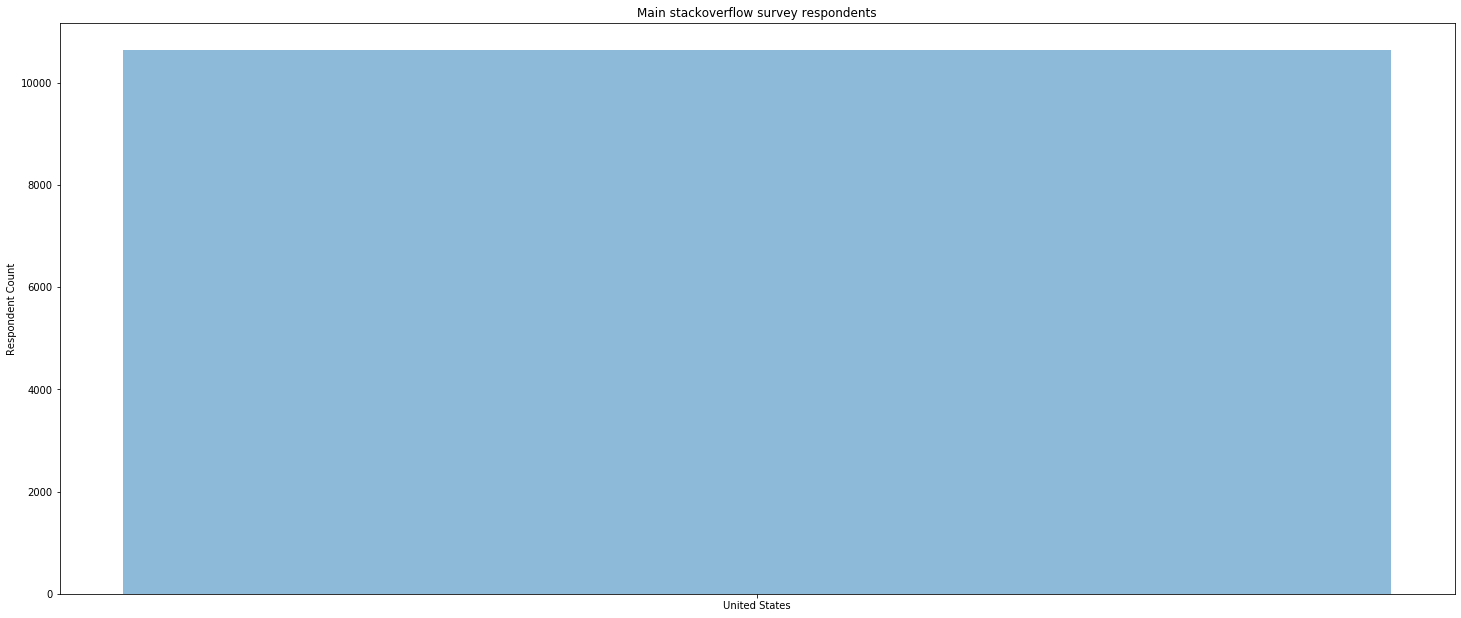

In [22]:
plt.bar(country_label, country_count, align='center', alpha=0.5)
plt.xticks(country_label)
plt.ylabel('Respondent Count')
plt.title('Main stackoverflow survey respondents')

plt.savefig("./Figure/CountryRespondents.png")
fig = plt.gcf()
fig.set_size_inches(25, 10.5)
plt.show()

In [23]:
country_label

['United States']

### Out of the 98,855 respondents, there were developers from 184 countries involved!
Out of the 184 countries the top contributing countries are
['United States',
 'India',
 'Germany',
 'United Kingdom',
 'Canada',
 'Russian Federation',
 'France',
 'Brazil',
 'Poland',
 'Australia',
 'Netherlands',
 'Spain',
 'Italy',
 'Ukraine',
 'Sweden',
 'Pakistan',
 'China',
 'Switzerland',
 'Turkey',
 'Israel']

---
## Now we check out the gender ratio

In [24]:
gender_responses = selected_response["Gender"]
# print(gender_responses)
total_gender_responses = []
for i in gender_responses: 
    if i != None:
        i = i.split(";") 
        if type(i) == list:
            for q in i :
                total_gender_responses.append(q)
        else:
            total_gender_responses.append(i)
        
        
set_gender_response = set(total_gender_responses)
print(set_gender_response)
# print(json.dumps(gender_set_responses , indent = 4))
# total_appearance_of_each_country = Counter(selected_response["Country"])

{'Transgender', 'Male', 'Non-binary, genderqueer, or gender non-conforming', 'Female'}


In [25]:
gender_dict = {}
gender_dict["Male"] = 0
gender_dict["Female"] = 0 
gender_dict["Others"] = 0
gender_dict["Undisclosed"] = 0
for i in selected_response["Gender"]:
#     print(i) 
    if i is None: 
        gender_dict["Undisclosed"] +=1 
    elif "Male" in i:
        gender_dict["Male"] += 1
    elif "Female" in i :
        gender_dict["Female"] +=1 
    else:
        gender_dict["Others"] +=1 
    

In [26]:
gender_count = []
gender_count.append(gender_dict["Male"])
gender_count.append(gender_dict["Female"])
gender_count.append(gender_dict["Undisclosed"])
gender_count.append(gender_dict["Others"])
gender_label = "Male" , "Female" , "Undisclosed" , "Others"

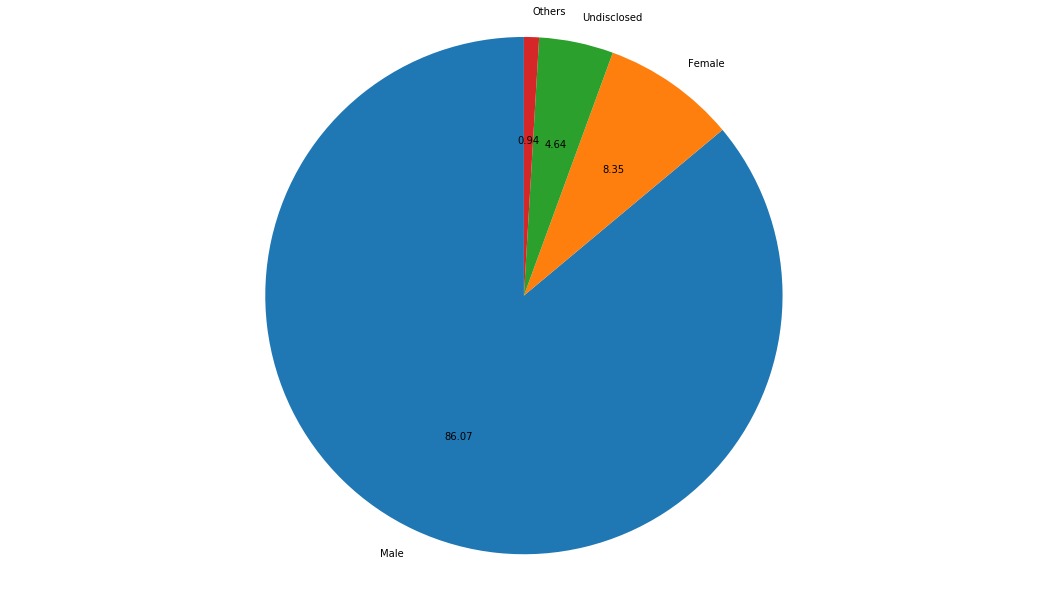

In [27]:
# GRAPHING GENDER
figureObject, axesObject = plt.subplots() 

plt.pie(gender_count,
        labels=gender_label, 
        autopct='%1.2f', 
        startangle=90) 

plt.axis('equal')

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.savefig("./Figure/GenderPlot.png")

plt.show()

In [28]:
plt.figure(figsize=(10,6))
temp = selected_response[selected_response.DevType == 'Data scientist or machine learning specialist']
temp = temp[temp.convertedsalary < 250000]
ax = sns.boxplot(x="Gender", 
                 y="convertedsalary", 
                 hue="Gender", 
                 data=temp)

TypeError: '<' not supported between instances of 'str' and 'int'

<Figure size 720x432 with 0 Axes>

---
## Now we visualize the age groups

In [ ]:
age_responses = selected_response["Age"]

In [ ]:
age_responses.unique()

In [ ]:
age_responses = selected_response.groupby("Age").nunique()

In [ ]:
age_responses = selected_response.Age.value_counts()

In [ ]:
age_label = []
age_value = []
for i in age_responses:
#     print*()
    age_label.append(age_responses[age_responses == i].index[0])
    age_value.append(i)

In [ ]:
fig1, ax1 = plt.subplots()
ax1.pie(age_value, labels=age_label, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.savefig("./Figure/age_pie")
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
temp = selected_response[selected_response.DevType == 'Data scientist or machine learning specialist']
temp = temp[temp.convertedsalary < 250000]
ax = sns.boxplot(x="Age", 
                 y="convertedsalary", 
                 hue="Age", 
                 data=temp)
plt.savefig("./Figure/boxplot age group.png")

---
## Visualize contribution to open source

In [ ]:
open_source_response = selected_response["OpenSource"]

In [ ]:
selected_response.convertedsalary = pd.to_numeric(selected_response.convertedsalary)

In [ ]:
selected_response.info()

In [ ]:
temp = selected_response[selected_response.DevType == 'Data scientist or machine learning specialist']
temp = temp[temp.convertedsalary < 250000]
ax = sns.boxplot(x="OpenSource", 
                 y="convertedsalary", 
                 hue="OpenSource", 
                 data=temp)

In [ ]:
open_source_label = []
open_source_count_total = []
for i in open_source_count_unique: 
    open_source_label.append(open_source_count_unique[open_source_count_unique == i ].index[0])
    open_source_count_total.append(i)

In [ ]:
fig1, ax1 = plt.subplots()
ax1.pie(open_source_count_total, labels=open_source_label, autopct='%1.1f%%', shadow=True,
        startangle=90)
ax1.axis('equal')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.savefig("./Figure/open_source")
plt.show()

In [ ]:
open_source_response = selected_response["OpenSource" , "Salary"]

In [ ]:
open_source_count_unique = selected_response.OpenSource.value_counts()

---
## Now we try to look at the types of job we get for each age group

In [ ]:
# jobs_to_year_dev = selected_response[["DevType" , "YearsCoding"]]

In [ ]:
# jobs_to_year_dev

In [ ]:
# jobs_to_year_dev.YearsCoding.unique()

In [ ]:
# jobs_to_years_series = jobs_to_year_dev.YearsCoding.value_counts()

In [ ]:
# jobs_to_years_dict = {} 
# for i in jobs_to_years_series: 
#     jobs_to_years_dict[str(jobs_to_years_series[jobs_to_years_series == i ].index[0])] = i 
# jobs_to_years_dict_keys = jobs_to_years_dict.keys()
# jobs_to_years_dict_value = jobs_to_years_dict.values()

In [ ]:
# group_jobs_to_year_dev = jobs_to_year_dev.groupby("DevType")

In [ ]:
# group_jobs_to_year_dev.first()

In [ ]:
# group_jobs_to_year_dev.get_group("Back-end developer")

Empty devtype responses 6757

In [ ]:
def query_year_and_dev():
    query_sql = "SELECT YearsCoding, DevType from " + main_table + " WHERE DevType is not null"
    c = conn.cursor()
    c.execute(query_sql)
    conn.commit()
    rows  = c.fetchall()
    return rows


In [ ]:
years_coding_and_dev_type = pd.DataFrame(query_year_and_dev(), columns = ["YearsCoding" , "DevType"])
years_coding_and_dev_type

In [ ]:
# Split options and find specific options
def find_set_dev_type():
    unique_list = []
    null_list_dev_type = []
    for i in years_coding_and_dev_type.DevType:
        if i is not None:
            split_list = i.split(";") 
            for i in split_list:
                unique_list.append(i)
        else :
            null_list_dev_type.append(i) 
    return set(unique_list)
    

In [ ]:
find_set_dev_type()

# DATA SCIENTIST
{
 'Data or business analyst',
 'Data scientist or machine learning specialist',
 }

# Software Developers
{'Back-end developer',  
 'Database administrator', 
 'Desktop or enterprise applications developer',
 'DevOps specialist', 
 'Embedded applications or devices developer',
 'Engineering manager',
 'Front-end developer',
 'Full-stack developer',
 'Game or graphics developer', 
 'Mobile developer', 
 'QA or test developer', 
 'System administrator'}

In [ ]:
data_science_position_titles = {
 'Data or business analyst',
 'Data scientist or machine learning specialist',
 } 

In [ ]:
def find_year_and_dev_by_DevType():
    found_data_scientist = []
    coding_years_set = []
    for individual_position_block in years_coding_and_dev_type.values:
        
        this_man_is_a_data_scientist = False
        if individual_position_block[1] is not None:
            individual_position_block_list = individual_position_block[1].split(";")
            for indi_positions in individual_position_block_list:
                if indi_positions in data_science_position_titles:
                    this_man_is_a_data_scientist = True
        if this_man_is_a_data_scientist == True:
            found_data_scientist.append(individual_position_block)
            coding_years_set.append(individual_position_block[0])
    coding_years_set = set(coding_years_set)
    return found_data_scientist, coding_years_set


found_years_devtype_ds , coding_years_set = find_year_and_dev_by_DevType() 

In [ ]:
def count_total_ds_in_age_group():
    total_ds_in_age_group = {}
    for i in range(0 , len(found_years_devtype_ds)): 
        try:
            total_ds_in_age_group[found_years_devtype_ds[i][0]] += 1
        except:
            total_ds_in_age_group[found_years_devtype_ds[i][0]] = 1
    return total_ds_in_age_group
total_ds_in_age_group = count_total_ds_in_age_group()

In [ ]:
# Sort in Age Order
total_ds_in_age_group = { '0-2 years': 1071, '3-5 years': 2798,'6-8 years': 2482,'9-11 years': 1553, '12-14 years': 1071,  '15-17 years': 887,  '18-20 years': 785,'24-26 years': 334, '21-23 years': 425, '27-29 years': 174, '30 or more years': 721}

In [ ]:
plt.bar(total_ds_in_age_group.keys(), total_ds_in_age_group.values(), align='center', alpha=0.5)
plt.ylabel('Number of Data Scientist Respondents')
plt.title('Data Scientist Age Groups')
fig = plt.gcf()
fig.set_size_inches(20, 10) 

plt.savefig("./Figure/Age_DataScientist.png")
plt.show()

In [ ]:
plt.figure(figsize=(15,6))
temp = selected_response[selected_response.DevType == 'Data scientist or machine learning specialist']
temp = temp[temp.convertedsalary < 250000]
ax = sns.boxplot(x="YearsCoding", 
                 y="convertedsalary", 
                 hue="YearsCoding", 
                 data=temp)
plt.savefig("./Figure/box plot years coding.png")

---
## Formal Education


In [ ]:
formal_education = selected_response[["FormalEducation" , "DevType"]]

In [ ]:
cleaned_formal_education = []
for i in formal_education.values:
#     print(i)
#     break
    
    if i is not None and i[1] is not None and i[0] is not None: 
        #split multiple jobs positions
        dev_type = i[1].split(";")
        this_man_data_scientist = False
        for jobs in dev_type:
            if jobs in data_science_position_titles:
                this_man_data_scientist = True
        if this_man_data_scientist:
            cleaned_formal_education.append(i[0])
possible_education_credentials = set(cleaned_formal_education)

In [ ]:
possible_education_credentials

In [ ]:
total_degree_for_ds = {}
for i in formal_education.values:
    if i is not None and i[1] is not None and i[0] is not None:
        try:
            total_degree_for_ds[i[0]] +=1
        except :
            total_degree_for_ds[i[0]]= 1

In [ ]:
total_degree_for_ds

In [ ]:
print_total_degree_keys = []
for i in total_degree_for_ds.keys():
    i = i.split(" " , 2) 
    print_total_degree_keys.append(i[0] + " " + i [1])

In [ ]:
plt.bar(print_total_degree_keys, list(total_degree_for_ds.values()), align='center', alpha=0.5)
plt.ylabel('Number of Data Scientist Respondents')
plt.title('Data Scientist Education Degree')
fig = plt.gcf()
fig.set_size_inches(20, 10) 

plt.savefig("./Figure/Degree Data Scientist.png")
plt.show()

In [ ]:
plt.figure(figsize=(15,6))
temp = selected_response[selected_response.DevType == 'Data scientist or machine learning specialist']
temp = temp[temp.convertedsalary < 250000]
ax = sns.boxplot(x="FormalEducation", 
                 y="convertedsalary", 
                 hue="FormalEducation", 
                 data=temp)
plt.xticks(rotation=10)
plt.savefig("./Figure/formal educaiton box plt.png")

---
## Language Worked with
+ language desire next year
 

In [ ]:
def query_languages_and_next_year():
    query_sql = "SELECT languageworkedwith, languagedesirenextyear from " + main_table + " WHERE languageworkedwith is not null OR languagedesirenextyear is not null AND country = 'United States' AND Student = 'No' AND employment = 'Employed full-time' AND convertedsalary is not null "
    c = conn.cursor()
    c.execute(query_sql)
    conn.commit()
    rows  = c.fetchall()
    return rows
def query_languages_and_next_year_ds():
    query_sql = "SELECT languageworkedwith, languagedesirenextyear,devtype from " + main_table + " WHERE languageworkedwith is not null OR languagedesirenextyear is not null and devtype is not null AND country = 'United States' AND Student = 'No' AND employment = 'Employed full-time' AND convertedsalary is not null "
    c = conn.cursor()
    c.execute(query_sql)
    conn.commit()
    rows  = c.fetchall()
    return rows
queried_language_and_next_year = pd.DataFrame(query_languages_and_next_year() , columns = ["LanguageWorkedWith" , "LanguagesNextYear"])
queried_language_and_next_year_ds = pd.DataFrame(query_languages_and_next_year_ds() , columns = ["LanguageWorkedWith" , "LanguagesNextYear", "DevType"])


In [ ]:
def find_languages_total_count():
    languages_all_this = {}
    languages_all_next = {}
    for i in queried_language_and_next_year.values: 
        if i is not None and i[0] is not None and i[1] is not None: 
            current_list = i[0].split(";") 
            next_list = i[1].split(";")
            for languages_current in current_list:
                try:
                    languages_all_this[languages_current] +=1
                except:
                    languages_all_this[languages_current] = 1
            for languages_next in next_list:
                try:
                    languages_all_next[languages_next] +=1
                except:
                    languages_all_next[languages_next] = 1
    return languages_all_this, languages_all_next
languages_all_this , languages_all_next = find_languages_total_count()

In [ ]:
def find_languages_total_count_ds():
    languages_all_this = {}
    languages_all_next = {}
    for i in queried_language_and_next_year_ds.values: 
        if i is not None and i[0] is not None and i[1] is not None and i[2] is not None:
            jobs_titles = i[2].split(";")  
            
            this_man_is_ds = False
            # Check if job is data scientist
            for job_indi in jobs_titles:
                if job_indi in data_science_position_titles:
                    this_man_is_ds = True
            if this_man_is_ds :
                current_list = i[0].split(";") 
                next_list = i[1].split(";")
                for languages_current in current_list:
                    try:
                        languages_all_this[languages_current] +=1
                    except:
                        languages_all_this[languages_current] = 1
                for languages_next in next_list:
                    try:
                        languages_all_next[languages_next] +=1
                    except:
                        languages_all_next[languages_next] = 1
    return languages_all_this, languages_all_next
languages_all_this_ds , languages_all_next_ds = find_languages_total_count_ds()

In [ ]:
dict_languages_current_next = {"Current" : languages_all_this , "Next Year" : languages_all_next}
languages_dataframe = pd.DataFrame(dict_languages_current_next)
languages_plot = languages_dataframe.plot( kind= 'bar' , secondary_y= 'amount' , rot= 0 )
fig = plt.gcf()
fig.set_size_inches(60, 10) 
plt.savefig("./Figure/Languages_this_next.png")
plt.show()

In [ ]:
dict_languages_current_next_ds = {"Current" : languages_all_this_ds , "Next Year" : languages_all_next_ds}
languages_dataframe_ds = pd.DataFrame(dict_languages_current_next_ds)
languages_plot_ds = languages_dataframe_ds.plot( kind= 'bar' , secondary_y= 'amount' , rot= 0 )
fig = plt.gcf()
fig.set_size_inches(60, 10) 
plt.savefig("./Figure/Languages_this_next_ds.png")
plt.show()

In [ ]:
dict_languages_current_next_ds_merge = {"Current" : languages_all_this , "Next Year" : languages_all_next , "CurrentDS" : languages_all_this_ds , "Next Year DS" : languages_all_next_ds}
languages_dataframe_ds_merge = pd.DataFrame(dict_languages_current_next_ds_merge)
languages_plot_ds = languages_dataframe_ds_merge.plot( kind= 'bar' , secondary_y= 'amount' , rot= 0 )
fig = plt.gcf()
fig.set_size_inches(60, 10) 
plt.savefig("./Figure/Languages_this_next_ds_merge.png")
plt.show()

---
## Platform 
+ platform desire next year

In [ ]:
def query_platforms_experience():
    query_sql = "SELECT platformworkedwith, platformdesirenextyear from " + main_table + " WHERE platformworkedwith is not null AND platformdesirenextyear is not null AND country = 'United States' AND Student = 'No' AND employment = 'Employed full-time' AND convertedsalary is not null "
    c = conn.cursor()
    c.execute(query_sql)
    conn.commit()
    rows  = c.fetchall()
    query_sql_ds = "SELECT platformworkedwith, platformdesirenextyear, devtype from " + main_table + " WHERE platformworkedwith is not null AND platformdesirenextyear is not null AND devtype is not null AND country = 'United States' AND Student = 'No' AND employment = 'Employed full-time' AND convertedsalary is not null "
    c = conn.cursor()
    c.execute(query_sql_ds)
    rows_ds  = c.fetchall()
    
    return rows, rows_ds
queried_platform, queried_platform_ds = query_platforms_experience()
queried_platforms_this_next = pd.DataFrame(queried_platform , columns = ["PlatformsCurrent" , "PlatformsNext"])
queried_platforms_this_next_ds = pd.DataFrame(queried_platform_ds , columns = ["PlatformsCurrent" , "PlatformsNext", "DevType"])

In [ ]:
def find_platforms_all():
    platforms_current = {}
    platforms_next = {}
    platforms_current_ds = {}
    platforms_next_ds = {}
    for i in queried_platforms_this_next_ds.values: 
        if i is not None and i[0] is not None and i[1] is not None:
            jobs_titles = i[2].split(";")  
            
            this_man_is_ds = False
            # Check if job is data scientist
            for job_indi in jobs_titles:
                if job_indi in data_science_position_titles:
                    this_man_is_ds = True
                     
            current_list = i[0].split(";") 
            next_list = i[1].split(";")
            for platforms_current_indi in current_list:
                try:
                    platforms_current[platforms_current_indi] +=1
                    if this_man_is_ds:
                        platforms_current_ds[platforms_current_indi] +=1
                except:
                    platforms_current[platforms_current_indi] = 1
                    if this_man_is_ds:
                        platforms_current_ds[platforms_current_indi] = 1 
            for platforms_next_indi in next_list:
                try:
                    platforms_next[platforms_next_indi] +=1
                    if this_man_is_ds:
                        platforms_next_ds[platforms_next_indi] +=1
                except:
                    platforms_next[platforms_next_indi] = 1
                    if this_man_is_ds:
                        platforms_next_ds[platforms_next_indi] = 1
             
                
                
    return platforms_current, platforms_next , platforms_current_ds, platforms_next_ds 
platforms_current , platforms_next, platforms_current_ds, platforms_next_ds  = find_platforms_all()

In [ ]:
# Overall normal + DS
dict_platforms_count = {"Current" : platforms_current , "Next Year" : platforms_next , "CurrentDS" : platforms_current_ds , "Next Year DS" : platforms_next_ds}
dict_platforms_count_df = pd.DataFrame(dict_platforms_count)
dict_platforms_count_df_plot = dict_platforms_count_df.plot( kind= 'bar' , secondary_y= 'amount' , rot= 0 )
fig = plt.gcf()
fig.set_size_inches(60, 10) 
plt.savefig("./Figure/platform_merge.png")
plt.show()

In [ ]:
# Overall normal 
dict_platforms_count_normal = {"Current" : platforms_current , "Next Year" : platforms_next }
dict_platforms_count_normal_df = pd.DataFrame(dict_platforms_count_normal)
dict_platforms_count_df_normal_plot = dict_platforms_count_normal_df.plot( kind= 'bar' , secondary_y= 'amount' , rot= 0 )
fig = plt.gcf()
fig.set_size_inches(60, 10) 
plt.savefig("./Figure/platform_normal.png")
plt.show()

In [ ]:
# Overall normal + DS
dict_platforms_count_ds = {"Current" : platforms_current_ds , "Next Year" : platforms_next_ds }
dict_platforms_count_ds_df = pd.DataFrame(dict_platforms_count_ds)
dict_platforms_count_df_ds_plot = dict_platforms_count_ds_df.plot( kind= 'bar' , secondary_y= 'amount' , rot= 0 )
fig = plt.gcf()
fig.set_size_inches(60, 10) 
plt.savefig("./Figure/platform_ds.png")
plt.show()

---
## IDE


In [ ]:
def query_ide():
    query_sql = "SELECT ide, devtype from " + main_table + " WHERE ide is not null AND devtype is not null AND country = 'United States' AND Student = 'No' AND employment = 'Employed full-time' AND convertedsalary is not null "
    c = conn.cursor()
    c.execute(query_sql)
    conn.commit()
    rows  = c.fetchall() 
    
    return rows  
queried_ide = pd.DataFrame(query_ide() , columns = ["IDE" , "DevType"])

In [ ]:
def find_ide_count():
    ide = {}
    ide_ds = {} 
    for i in queried_ide.values: 
        if i is not None and i[0] is not None and i[1] is not None:
            jobs_titles = i[1].split(";")  
            
            this_man_is_ds = False
            # Check if job is data scientist
            for job_indi in jobs_titles:
                if job_indi in data_science_position_titles:
                    this_man_is_ds = True
                     
            current_list = i[0].split(";")  
            for ide_indi in current_list:
                try:
                    ide[ide_indi] +=1
                    if this_man_is_ds:
                        ide_ds[ide_indi] +=1
                except:
                    ide[ide_indi] = 1
                    if this_man_is_ds:
                        ide_ds[ide_indi] = 1   
    return  ide , ide_ds 
ide , ide_ds = find_ide_count()

In [ ]:
# Overall normal 
dict_ids_count = {"All" : ide , "DS Nerds :D" : ide_ds }
dict_ids_count_df = pd.DataFrame(dict_ids_count)
dict_ids_count_df_plot = dict_ids_count_df.plot( kind= 'bar' , secondary_y= 'amount' , rot= 0 )
fig = plt.gcf()
fig.set_size_inches(50, 10) 
plt.savefig("./Figure/ide_choices.png")
plt.show()

In [ ]:
# Overall normal 
dict_ids_count = { "DS Nerds :D" : ide_ds }
dict_ids_count_df = pd.DataFrame(dict_ids_count)
dict_ids_count_df_plot = dict_ids_count_df.plot( kind= 'bar' , secondary_y= 'amount' , rot= 0 )
fig = plt.gcf()
fig.set_size_inches(50, 10) 
plt.savefig("./Figure/ide_choices_ds.png")
plt.show()

---
## Operating System - Data Scientist
## Operating System - Software Developer

In [ ]:
def query_os():
    query_sql = "SELECT operatingsystem, devtype from " + main_table + " WHERE operatingsystem is not null AND devtype is not null AND country = 'United States' AND Student = 'No' AND employment = 'Employed full-time' AND convertedsalary is not null "
    c = conn.cursor()
    c.execute(query_sql)
    conn.commit()
    rows  = c.fetchall() 
    
    return rows  
queried_os = pd.DataFrame(query_os() , columns = ["IDE" , "DevType"])

In [ ]:
def find_os_count():
    os = {}
    os_ds = {} 
    for i in queried_os.values: 
        if i is not None and i[0] is not None and i[1] is not None:
            jobs_titles = i[1].split(";")  
            
            this_man_is_ds = False
            # Check if job is data scientist
            for job_indi in jobs_titles:
                if job_indi in data_science_position_titles:
                    this_man_is_ds = True
                     
            current_list = i[0].split(";")  
            for os_options in current_list:
                try:
                    os[os_options] +=1
                    if this_man_is_ds:
                        os_ds[os_options] +=1
                except:
                    os[os_options] = 1
                    if this_man_is_ds:
                        os_ds[os_options] = 1   
    return os , os_ds 
os , os_ds =  find_os_count()

In [ ]:
# Overall normal 
dict_os_count = {"All" : os , "DS Nerds :D" : os_ds }
dict_os_count_df = pd.DataFrame(dict_os_count)
dict_os_count_df_plt = dict_os_count_df.plot( kind= 'bar' , secondary_y= 'amount' , rot= 0 )
fig = plt.gcf()
fig.set_size_inches(15, 10) 
plt.savefig("./Figure/os.png")
plt.show()

In [ ]:
os_ds

---
## SALARY
- overall salary describe done
- median/ mean done
- countries
- gender done
- devtype
- languages 


In [ ]:
def query_salary_respondents():
    query_sql = "SELECT convertedsalary from " + main_table + " WHERE country = 'United States' AND Student = 'No' AND employment = 'Employed full-time' AND convertedsalary is not null "
    c = conn.cursor()
    c.execute(query_sql)
    conn.commit()
    rows  = c.fetchall() 
    none_count = 0
    has_value_count = 0
    for i in rows: 
        if i[0] is None:
            none_count +=1
        else:
            has_value_count+=1 
    return has_value_count / ( none_count + has_value_count)
percentage_salary_respondents = query_salary_respondents()

In [ ]:
print("Only %1.3f of respondents replied their salary" % ( percentage_salary_respondents))

In [ ]:
def query_female_salary():
    
    query_sql = "SELECT convertedsalary, gender  from " + main_table + " WHERE gender like 'Female'"
    c = conn.cursor()
    c.execute(query_sql)
    conn.commit()
    rows  = c.fetchall() 
    female_salary_list = []
    for i in rows:
        if i[0] is not None:
#             print(float(i[0]))
            female_salary_list.append(float(i[0]))
    return female_salary_list
female_salary = pd.DataFrame(query_female_salary() , columns = ["Female Salary"])
print(female_salary.describe().round())
    

In [ ]:
def query_male_salary():
    
    query_sql = "SELECT convertedsalary, gender  from " + main_table + " WHERE gender like 'Male'"
    c = conn.cursor()
    c.execute(query_sql)
    conn.commit()
    rows  = c.fetchall() 
    male_salary_list = []
    for i in rows:
        if i[0] is not None:
#             print(float(i[0]))
            male_salary_list.append(float(i[0]))
    return male_salary_list
male_salary = pd.DataFrame(query_male_salary() , columns = ["Male Salary"])
print(male_salary.describe().round())
    

In [ ]:
def query_all_salary():
    
    query_sql = "SELECT convertedsalary, gender  from " + main_table 
    c = conn.cursor()
    c.execute(query_sql)
    conn.commit()
    rows  = c.fetchall() 
    all_salary_list = []
    for i in rows:
        if i[0] is not None:
#             print(float(i[0]))
            all_salary_list.append(float(i[0]))
    return all_salary_list
all_salary = pd.DataFrame(query_all_salary() , columns = ["All Salary"])
print(all_salary.describe().round())
    

In [ ]:
def query_salary():
    query_sql = "SELECT convertedsalary, devtype, country  from " + main_table + " WHERE convertedsalary is not null AND country is not null and devtype is not null"
    c = conn.cursor()
    c.execute(query_sql)
    conn.commit()
    rows  = c.fetchall()  
    return rows  

queried_salary = pd.DataFrame(query_salary() , columns = ["Salary", "DevType", "Country"])

In [ ]:
def indi_salary_to_country_list():
    country_salary_dict = {}
    country_salary_dict_ds = {} 
    for i in queried_salary.values:
    #     print(i)
    #     new_i = i[0]
    #     print(new_i)

        #Check if DS
        this_man_is_ds = False
        jobs_split = i[1].split(";")
        for q in jobs_split:
            if q in data_science_position_titles:
                this_man_is_ds = True

        if i[0] is not None:
            salary_int_value = round(float(i[0]))
            try:
                country_salary_dict[i[2]].append(salary_int_value)
                if this_man_is_ds:
                    country_salary_dict_ds[i[2]].append(salary_int_value) 
            except:
                country_salary_dict[i[2]] = [] 
                country_salary_dict[i[2]].append(salary_int_value) 
                if this_man_is_ds:
                    country_salary_dict_ds[i[2]] = []
                    country_salary_dict_ds[i[2]].append(salary_int_value) 
    #     print(country_salary_dict)
    #     print(country_salary_dict_ds) 
    return country_salary_dict , country_salary_dict_ds
country_salary_dict , country_salary_dict_ds = indi_salary_to_country_list()

In [ ]:
def find_median_country_salary():
    new_country_salary_mean_dict = {}
    for i in country_salary_dict.keys(): 
        each_country_list = country_salary_dict[i]
    #     print(statistics.median(each_country_list))
    #     print(statistics.mean(each_country_list))
        try:
            new_country_salary_mean_dict[i] = each_country_list
        except:
            new_country_salary_mean_dict[i] = []
            new_country_salary_mean_dict[i] = each_country_list
    # print(new_country_salary_mean_dict)
    medium_salary_keys = {}
    for i in new_country_salary_mean_dict.keys():
        medium_per_country = statistics.median(new_country_salary_mean_dict[i])
    #     print(medium_per_country)
        try:
            medium_salary_keys[i] = medium_per_country
        except:
            medium_salary_keys[i] = []
            medium_salary_keys[i] = medium_per_country
    top_values = {}
    for i in medium_salary_keys.keys():
        if medium_salary_keys[i] > 70000:
            try:
                top_values[i] = medium_salary_keys[i]
            except:
                top_values[i] = 0
                top_values[i] = medium_salary_keys[i]
    return top_values
def find_median_country_salary_ds():
    new_country_salary_mean_dict = {}
    for i in country_salary_dict_ds.keys(): 
        each_country_list = country_salary_dict_ds[i]
    #     print(statistics.median(each_country_list))
    #     print(statistics.mean(each_country_list))
        try:
            new_country_salary_mean_dict[i] = each_country_list
        except:
            new_country_salary_mean_dict[i] = []
            new_country_salary_mean_dict[i] = each_country_list
    # print(new_country_salary_mean_dict)
    medium_salary_keys = {}
    for i in new_country_salary_mean_dict.keys():
        medium_per_country = statistics.median(new_country_salary_mean_dict[i])
    #     print(medium_per_country)
        try:
            medium_salary_keys[i] = medium_per_country
        except:
            medium_salary_keys[i] = []
            medium_salary_keys[i] = medium_per_country
    top_values = {}
    for i in medium_salary_keys.keys():
        if medium_salary_keys[i] > 70000:
            try:
                top_values[i] = medium_salary_keys[i]
            except:
                top_values[i] = 0
                top_values[i] = medium_salary_keys[i]
    return top_values 

top_values = find_median_country_salary()
top_values_ds = find_median_country_salary_ds()

In [ ]:
# Overall normal 
def show_all_country_salary():
    median_salary_country = {"All" : top_values  }
    median_salary_country_df = pd.DataFrame(median_salary_country)
    median_salary_country_df_plt = median_salary_country_df.plot( kind= 'bar' , secondary_y= 'amount' , rot= 0 )
    fig = plt.gcf()
    fig.set_size_inches(20, 10) 
    plt.savefig("./Figure/salary country.png")
    plt.show()
def  show_all_country_salary_ds():
    median_salary_country = {"DS" : top_values_ds  }
    median_salary_country_df = pd.DataFrame(median_salary_country)
    median_salary_country_df_plt = median_salary_country_df.plot( kind= 'bar' , secondary_y= 'amount' , rot= 0 )
    fig = plt.gcf()
    fig.set_size_inches(20, 10) 
    plt.savefig("./Figure/salary country ds.png")
    plt.show()
show_all_country_salary()
show_all_country_salary_ds()

In [ ]:
def query_salary_language():
    query_sql = "SELECT convertedsalary, devtype, languageworkedwith  from " + main_table + " WHERE convertedsalary is not null AND languageworkedwith is not null and devtype is not null"
    c = conn.cursor()
    c.execute(query_sql)
    conn.commit()
    rows  = c.fetchall()  
    return rows  

queried_salary_language = pd.DataFrame(query_salary_language() , columns = ["Salary", "DevType", "Language"])

In [ ]:
def indi_salary_to_language_list():
    language_salary_dict = {}
    language_salary_dict_ds = {} 
    for i in queried_salary_language.values: 
        this_man_is_ds = False
        jobs_split = i[1].split(";")
        for q in jobs_split:
            if q in data_science_position_titles:
                this_man_is_ds = True
        language_split = i[2].split(";")
        for indi_language in language_split:
            
            if i[0] is not None:
                salary_int_value = round(float(i[0]))
                try:
                    language_salary_dict[indi_language].append(salary_int_value)
                    if this_man_is_ds:
                        language_salary_dict_ds[indi_language].append(salary_int_value) 
                except:
                    language_salary_dict[indi_language] = [] 
                    language_salary_dict[indi_language].append(salary_int_value) 
                    if this_man_is_ds:
                        language_salary_dict_ds[indi_language] = []
                        language_salary_dict_ds[indi_language].append(salary_int_value)  
#     print(language_salary_dict)
    return language_salary_dict , language_salary_dict_ds
language_salary_dict , language_salary_dict_ds = indi_salary_to_language_list()

In [ ]:
def find_median_language_salary():
    new_language_salary_mean_dict = {}
    for i in language_salary_dict.keys(): 
        each_language_list = language_salary_dict[i]
    #     print(statistics.median(each_country_list))
    #     print(statistics.mean(each_country_list))
        try:
            new_language_salary_mean_dict[i] = each_language_list
        except:
            new_language_salary_mean_dict[i] = []
            new_language_salary_mean_dict[i] = each_language_list
    # print(new_country_salary_mean_dict)
    medium_salary_keys = {}
    for i in new_language_salary_mean_dict.keys():
        medium_per_language = statistics.median(new_language_salary_mean_dict[i])
    #     print(medium_per_country)
        try:
            medium_salary_keys[i] = medium_per_language
        except:
            medium_salary_keys[i] = []
            medium_salary_keys[i] = medium_per_language
    top_values = {}
    for i in medium_salary_keys.keys():
        if medium_salary_keys[i] > 50000:
            try:
                top_values[i] = medium_salary_keys[i]
            except:
                top_values[i] = 0
                top_values[i] = medium_salary_keys[i]
    return top_values
def find_median_language_salary_ds():
    new_language_salary_mean_dict = {}
    for i in language_salary_dict_ds.keys(): 
        each_language_list = language_salary_dict_ds[i]
    #     print(statistics.median(each_country_list))
    #     print(statistics.mean(each_country_list))
        try:
            new_language_salary_mean_dict[i] = each_language_list
        except:
            new_language_salary_mean_dict[i] = []
            new_language_salary_mean_dict[i] = each_language_list
    # print(new_country_salary_mean_dict)
    medium_salary_keys = {}
    for i in new_language_salary_mean_dict.keys():
        medium_per_country = statistics.median(new_language_salary_mean_dict[i])
    #     print(medium_per_country)
        try:
            medium_salary_keys[i] = medium_per_country
        except:
            medium_salary_keys[i] = []
            medium_salary_keys[i] = medium_per_country
    top_values = {}
    for i in medium_salary_keys.keys():
        if medium_salary_keys[i] > 60000:
            try:
                top_values[i] = medium_salary_keys[i]
            except:
                top_values[i] = 0
                top_values[i] = medium_salary_keys[i]
    return top_values 

top_values_language = find_median_language_salary()
top_values_language_ds = find_median_language_salary_ds()

In [ ]:
top_values_language

In [ ]:
top_values_language_ds

In [ ]:
# Overall normal 
def show_all_language_salary():
    median_salary_language = {"All" : top_values_language  }
    median_salary_language_df = pd.DataFrame(median_salary_language)
    median_salary_language_df_plt = median_salary_language_df.plot( kind= 'bar' , secondary_y= 'amount' , rot= 0 )
    fig = plt.gcf()
    fig.set_size_inches(20, 10) 
    plt.savefig("./Figure/salary language.png")
    plt.show()
def  show_all_language_salary_ds():
    median_salary_language = {"DS" : top_values_language_ds  }
    median_salary_language_df = pd.DataFrame(median_salary_language)
    median_salary_language_df_plt = median_salary_language_df.plot( kind= 'bar' , secondary_y= 'amount' , rot= 0 )
    fig = plt.gcf()
    fig.set_size_inches(20, 10) 
    plt.savefig("./Figure/salary language ds.png")
    plt.show()
show_all_language_salary()
show_all_language_salary_ds()

In [ ]:
execute_sql("SELECT * FROM stack_overflow_survey \
             WHERE country = 'United States' \
             AND Student = 'No' \
             AND employment = 'Employed full-time'\
             AND convertedsalary is not null")

